## How to Improve The Models

In this section, we will focus on predicting the total score rather than the individual traits from the rubric. The reasons for this approach are:

- **Time Limitations** 
- **Data Limitations**: The data does not indicate which trait score maps to specific rubric criteria, such as style and conventions (grammar). For example, conventions might be better handled by a separate model due to its more objective nature.

Based on the available information, it is unclear how the models were initially built. What we do know is that neither model performed particularly well concerning the Quadratic Weighted Kappa (QWK) metric. Model 1 had a QWK score of 0.336, and Model 2 had a score of 0.344. While these scores indicate some degree of agreement, they fall short of demonstrating robust alignment with human raters. This presents an opportunity to improve these models' performance.

### From the Research

After initial research into this problem, I identified three potential ways to improve automated assessment scoring:

1. **Feature Extraction Methods**: The models may be using older feature extraction methods, such as bag of words. In a comparative study by Ramesh & Sanampudi (2022), it was found that models using pre-trained word embeddings like Word2Vec and Glove as part of their classification, regression, or LSTM-based models performed better in terms of QWK scores.
   
2. **Large Language Models (LLMs)**: Recent literature discusses LLMs for assessment scoring. While they did not outperform state-of-the-art models in pure assessment scoring (Mansour et al., 2024), they show promise in providing feedback to students and excel at grading objective assessments, such as those in science (Impey et al., 2024).

3. **Fine-Tuning Pre-trained Language Models**: Fine-tuning a pre-trained language model such as BERT has shown extraordinary abilities in representation and generalization (Yang et al., 2020).

The most promising option is to apply transfer learning to a pre-trained BERT model and fine-tune it using the given data, which is outlined in the rest of this notebook.

### Summary of Results

The fine-tuned BERT model was evaluated with a QWK score of 0.79, which is a significant improvement over the previous models. This high level of agreement suggests that the model's predictions are close to the actual scores.

However, in Yang et al. (2020), a R2BERT model (BERT with Regression and Ranking) achieved a QWK score of 0.84 on the same dataset. Considering the rapid advancements in this field, it is likely that newer models have achieved even better scores.

### Prepping The Data

Follow the same method as the previous notebook.


In [1]:
import pandas as pd
import numpy as np

# Path to the CSV file
essay_path = 'essay-7-all.csv'
results_3_path = 'results-3.csv'
results_4_path = 'results-4.csv'

# Reading the CSV file into a DataFrame
essay_df = pd.read_csv(essay_path)
results_3_df = pd.read_csv(results_3_path)
results_4_df = pd.read_csv(results_4_path)

# Removing columns where all values are null
essay_df = essay_df.dropna(axis=1, how='all')
results_3_df = results_3_df.dropna(axis=1, how='all')
results_4_df = results_4_df.dropna(axis=1, how='all')


# Remove the error records from both datasets
# Filtering out rows where 'error_count' is greater than 0
results_3_df = results_3_df[results_3_df['error_count'] == 0]
results_4_df = results_4_df[results_4_df['error_count'] == 0]

# Checking the uniqueness of essay_id in each dataframe
if (essay_df['essay_id'].nunique() == len(essay_df) and
    results_3_df['essay_id'].nunique() == len(results_3_df) and
    results_4_df['essay_id'].nunique() == len(results_4_df)):

    # Selecting and renaming the necessary columns from essay_df, and making a copy
    essay_columns = essay_df[['essay_id', 'essay', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_domain1', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_domain1']].copy()
    essay_columns.rename(columns={'rater1_domain1': 'rater1_total', 'rater2_domain1': 'rater2_total'}, inplace=True)

    # Selecting, renaming, and calculating the total score for results_3_df, and making a copy
    results_3_columns = results_3_df[['essay_id', 'model', 'autoscore_trait1', 'autoscore_trait2', 'autoscore_trait3', 'autoscore_trait4']].copy()
    results_3_columns.rename(columns={
        'model': 'model_1_name',
        'autoscore_trait1': 'model_1_trait1',
        'autoscore_trait2': 'model_1_trait2',
        'autoscore_trait3': 'model_1_trait3',
        'autoscore_trait4': 'model_1_trait4'
    }, inplace=True)
    results_3_columns['model_1_total_score'] = results_3_columns.loc[:, ['model_1_trait1', 'model_1_trait2', 'model_1_trait3', 'model_1_trait4']].sum(axis=1)

    # Selecting, renaming, and calculating the total score for results_4_df, and making a copy
    results_4_columns = results_4_df[['essay_id', 'model', 'autoscore_trait1', 'autoscore_trait2', 'autoscore_trait3', 'autoscore_trait4']].copy()
    results_4_columns.rename(columns={
        'model': 'model_2_name',
        'autoscore_trait1': 'model_2_trait1',
        'autoscore_trait2': 'model_2_trait2',
        'autoscore_trait3': 'model_2_trait3',
        'autoscore_trait4': 'model_2_trait4'
    }, inplace=True)
    results_4_columns['model_2_total_score'] = results_4_columns.loc[:, ['model_2_trait1', 'model_2_trait2', 'model_2_trait3', 'model_2_trait4']].sum(axis=1)

    # Merging the DataFrames on 'essay_id'
    merged_df = pd.merge(essay_columns, results_3_columns, on='essay_id', how='left')
    df = pd.merge(merged_df, results_4_columns, on='essay_id', how='left')

    # Remove all rows with any missing values
    df = df.dropna()

else:
    print("Data integrity check failed: duplicate essay_id found in one or more DataFrames.")



# Calculate the whole number average of human rater scores for each trait and create new columns
df['human_avg_trait1'] = np.round(df[['rater1_trait1', 'rater2_trait1']].mean(axis=1))
df['human_avg_trait2'] = np.round(df[['rater1_trait2', 'rater2_trait2']].mean(axis=1))
df['human_avg_trait3'] = np.round(df[['rater1_trait3', 'rater2_trait3']].mean(axis=1))
df['human_avg_trait4'] = np.round(df[['rater1_trait4', 'rater2_trait4']].mean(axis=1))

# Calculate the overall whole number average score combining all traits from both raters
df['human_avg_score'] = np.round(df[['rater1_total', 'rater2_total']].mean(axis=1))


# Note on scoring:
# This approach of averaging and rounding might still favor the higher marker, especially noticeable with only two raters.
# Ideally, having an odd number of raters, such as three, could help mitigate this bias, as it allows for a median value that might better represent a consensus score.

print("Shape of the combined DataFrame:", df.shape)

Shape of the combined DataFrame: (1542, 29)


1. **EssayDataset Class**:
   - Manages essays and their scores.
   - Provides methods to get the number of essays and to retrieve a specific essay and its score.

2. **collate_batch Function**:
   - Prepares a batch of essays and scores for training.
   - Pads essays to the same length and converts scores to tensors.
   - Returns the processed batch for use in model training.

In [2]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch

class EssayDataset(Dataset):
    def __init__(self, essays, scores):
        self.essays = essays
        self.scores = scores

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        # Make sure essays are already tokenized and converted into tensors here
        return self.essays[idx], self.scores[idx]

def collate_batch(batch):
    essay_tensors, scores = zip(*batch)
    essays_padded = pad_sequence(essay_tensors, batch_first=True, padding_value=0)
    scores_tensor = torch.tensor(scores, dtype=torch.float)  # Ensure scores are correctly formatted as tensors
    return essays_padded, scores_tensor


### EssayScoringModel Class
   - Initializes with a pre-trained BERT model and a regression layer.
   - Implements a forward method to pass input through BERT and then through the regression layer to output a score.

In [3]:
from transformers import BertModel
from torch import nn

class EssayScoringModel(nn.Module):
    def __init__(self):
        super(EssayScoringModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')  # Load pre-trained BERT
        self.regressor = nn.Linear(768, 1)  # A regression layer: BERT's hidden size to 1 output

    def forward(self, input_ids, attention_mask=None):
        # Forward pass through BERT and the regressor
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Get the pooled output features from BERT
        score = self.regressor(pooled_output)  # Pass BERT output through the regressor to get the score
        return score


/Users/seanmccrossan/.pyenv/versions/3.10.4/envs/learnosity/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparing Data for BERT Model

1. **Tokenization**:
   - Load the pre-trained BERT tokenizer and tokenize each essay, adding special tokens and truncating to 512 tokens.

2. **Train-Test Split**:
   - Split the data into training (70%) and testing (30%) datasets based on the calculated size.

3. **Custom Collate Function**:
   - Define a function to prepare batches by padding essays to the same length and converting scores to tensors.

4. **Data Loaders**:
   - Create DataLoader objects for training and testing datasets, using the custom collate function, parallel data loading, and pinned memory for efficiency.


In [4]:
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the essays and convert them to tensors
df['tokenized_essays'] = df['essay'].apply(lambda essay: tokenizer.encode(essay, add_special_tokens=True, truncation=True, max_length=512))
df['tokenized_essays'] = df['tokenized_essays'].apply(lambda x: torch.tensor(x))

# Determine the size of training data (80% for training, 20% for testing as an example)
train_size = int(0.7 * len(df))

# Now, when initializing the dataset, ensure you pass tensors
train_dataset = EssayDataset(df['tokenized_essays'][:train_size].tolist(), df['human_avg_score'][:train_size].tolist())
test_dataset = EssayDataset(df['tokenized_essays'][train_size:].tolist(), df['human_avg_score'][train_size:].tolist())

# Define the collate function if not defined
def collate_batch(batch):
    essay_tensors, scores = zip(*batch)
    essays_padded = pad_sequence(essay_tensors, batch_first=True, padding_value=0)
    return essays_padded, torch.tensor(scores)

# Data loaders with the proper collate function
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch, num_workers=4, pin_memory=True)

### Training the Model

1. **Setup**:
   - **Device Selection**: Determines whether to use a GPU or CPU for training.
   - **Model and Optimizer Initialization**: Loads the essay scoring model and sets up the AdamW optimizer.
   - **Loss Function**: Uses Mean Squared Error (MSE) to calculate the difference between predicted and actual scores.
   - **Gradient Scaling**: Applies mixed precision training for efficiency.
   - **Learning Rate Scheduler**: Gradually decreases the learning rate to improve training stability.
   - **Early Stopping Criteria**: Stops training if no significant improvement is seen over a set number of epochs.

2. **Training Loop**:
   - Processes data in batches, making predictions and calculating loss.
   - Updates the model weights periodically to simulate larger batch sizes.
   - Adjusts the learning rate according to the scheduler.
   - Tracks and prints the average loss for each epoch.

3. **Model Saving and Early Stopping**:
   - Saves the model when it shows improved performance.
   - Stops training early if there are multiple epochs without significant loss improvement.

In [5]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.nn import MSELoss
from torch.cuda.amp import GradScaler, autocast
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EssayScoringModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)  # Using AdamW optimizer with a different learning rate
criterion = MSELoss()
scaler = GradScaler()  # For mixed precision training

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decays the learning rate of each parameter group by gamma every step_size epochs

best_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement before stopping
no_improvement_epochs = 0
improvement_threshold = 1e-4  # Minimum change to be considered an improvement
accumulation_steps = 4
optimizer.zero_grad()
losses = []  # List to store the average loss of each epoch

for epoch in range(50):
    model.train()
    total_loss = 0
    for i, (essays, scores) in enumerate(train_loader):
        essays = essays.to(device)
        scores = scores.to(device).float()

        with autocast():
            predictions = model(essays).squeeze()
            loss = criterion(predictions, scores) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)  # Append the average loss
    scheduler.step()  # Adjust the learning rate based on the number of epochs
    print(f"Epoch {epoch}, Loss: {avg_loss}, LR: {scheduler.get_last_lr()}")

    if avg_loss < best_loss - improvement_threshold:
        best_loss = avg_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), 'essay_scoring_model.pth')
        print("Saved improved model with loss: {:.4f}".format(best_loss))
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break


/Users/seanmccrossan/.pyenv/versions/3.10.4/envs/learnosity/lib/python3.10/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/seanmccrossan/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/seanmccrossan/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'EssayDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/seanmccrossan/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/seanmccrossan/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'EssayDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/seanmccrossan/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/seanmccrossan/.pyenv/versions/3.10.4/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'EssayDataset' on <module '__main__' (built-in)>


RuntimeError: DataLoader worker (pid(s) 9275) exited unexpectedly

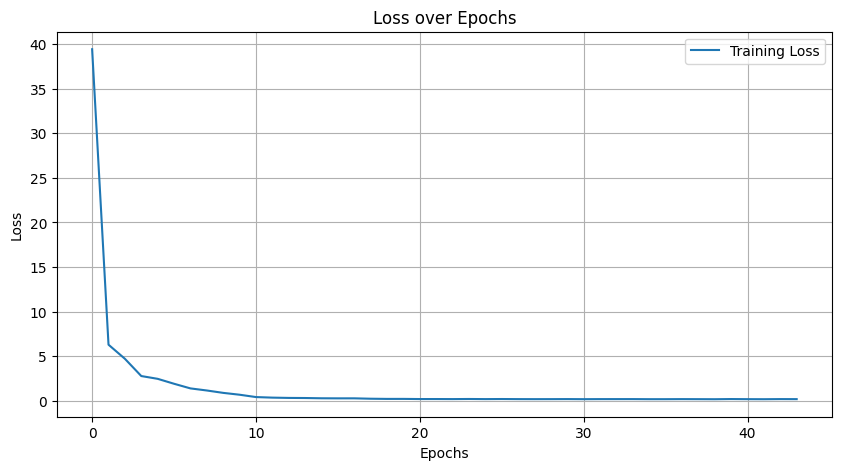

In [8]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Loading the Model


In [9]:
model = EssayScoringModel().to(device)
model.load_state_dict(torch.load('essay_scoring_model.pth'))
model.eval()

EssayScoringModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
test_scores = []
actual_scores = []

with torch.no_grad():  # Disable gradient computation for inference
    for essays, scores in test_loader:
        essays = essays.to(device)
        scores = scores.to(device)

        predictions = model(essays).squeeze()
        test_scores.extend(predictions.cpu().numpy())  # Store predictions
        actual_scores.extend(scores.cpu().numpy())  # Store actual scores


### Model Evaluation Results

These results compare the model's predicted test scores with the actual test scores:

- **Mean Squared Error (MSE): 2.02**
  - This value indicates the average squared difference between the predicted and actual scores. A lower MSE signifies better accuracy. In this case, the average squared error is relatively low, suggesting decent prediction performance.

- **Mean Absolute Error (MAE): 1.05**
  - This value measures the average absolute difference between the predicted and actual scores. A lower MAE indicates more precise predictions. Here, the average error is about 1 point, which indicates reasonably accurate predictions.

- **Root Mean Squared Error (RMSE): 1.42**
  - This metric gives the square root of the average squared differences between predicted and actual scores. It is sensitive to larger errors, indicating that the model’s predictions are, on average, 1.42 points off.

- **R-squared Score: 0.60**
  - This metric indicates how well the model's predictions explain the variability of the actual scores. An R-squared value of 0.60 means that the model explains 60% of the variance in the actual scores, demonstrating a good but not perfect fit.

- **Quadratic Weighted Kappa (QWK): 0.79**
  - This metric measures the agreement between the predicted and actual scores while accounting for the agreement occurring by chance. A QWK of 0.79 indicates a high level of agreement, suggesting that the model's predictions are close to the actual scores.

- **Pearson Correlation: 0.79**
  - This value indicates a strong positive linear relationship between the predicted and actual scores. The high correlation, with a very low P-value, suggests that the model's predictions are highly aligned with the actual scores.

- **Spearman Correlation: 0.79**
  - This value measures the rank-order relationship between the predicted and actual scores. A high Spearman correlation, with a very low P-value, indicates that the model's predictions preserve the order of the actual scores well.

### Summary
- The model shows reasonably accurate predictions with low average errors (MAE of 1.05 and RMSE of 1.42).
- It explains 60% of the variance in the actual scores, indicating a good fit.
- The high Quadratic Weighted Kappa (0.79) suggests strong agreement with actual scores.
- Both Pearson (0.79) and Spearman (0.79) correlations indicate a strong alignment between predicted and actual scores.

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Convert predictions and actual scores to the correct format
test_scores = np.round(test_scores)  # Round predictions to the nearest whole number

# Calculate MSE and other relevant metrics
mse = mean_squared_error(actual_scores, test_scores)
mae = mean_absolute_error(actual_scores, test_scores)
r2 = r2_score(actual_scores, test_scores)  # Coefficient of determination

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")


Mean Squared Error: 2.0215983390808105
Mean Absolute Error: 1.0539957284927368
R-squared Score: 0.5987868262558772


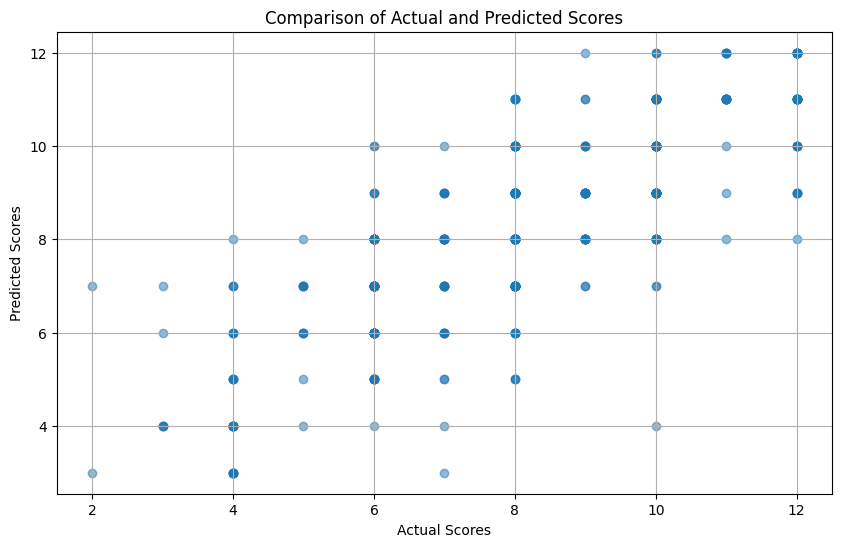

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(actual_scores, test_scores, alpha=0.5)
plt.title('Comparison of Actual and Predicted Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.grid(True)
plt.show()


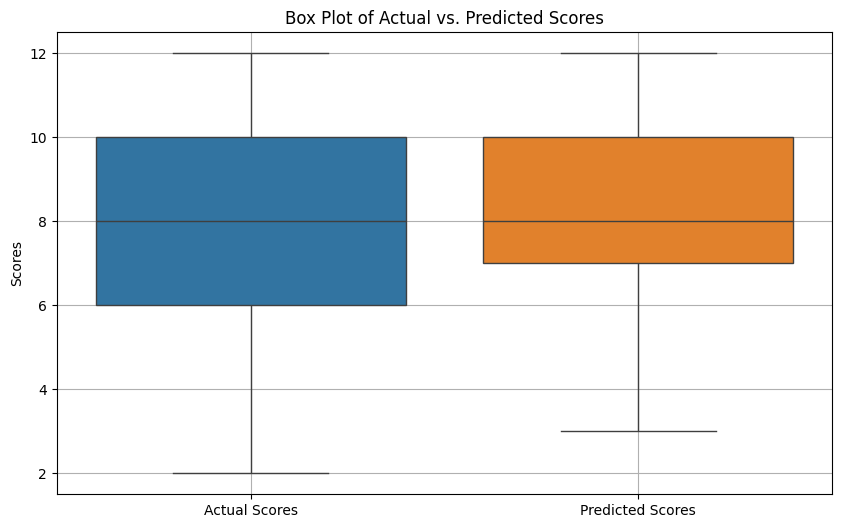

In [13]:
import seaborn as sns

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Actual Scores': actual_scores,
    'Predicted Scores': test_scores
})

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_data)
plt.title('Box Plot of Actual vs. Predicted Scores')
plt.ylabel('Scores')
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr
import numpy as np



# Calculate Quadratic Weighted Kappa
qwk_total = cohen_kappa_score(actual_scores, test_scores, weights='quadratic')
print(f"Quadratic Weighted Kappa: {qwk_total}")

# Calculate Pearson and Spearman correlations
pearson_corr_total, p_pearson_total = pearsonr(actual_scores, test_scores)
spearman_corr_total, p_spearman_total = spearmanr(actual_scores, test_scores)
print(f"Pearson Correlation: {pearson_corr_total}, P-value: {p_pearson_total}")
print(f"Spearman Correlation: {spearman_corr_total}, P-value: {p_spearman_total}")

# Calculate MAE and RMSE
mae_total = mean_absolute_error(actual_scores, test_scores)
rmse_total = np.sqrt(mean_squared_error(actual_scores, test_scores))
print(f"Mean Absolute Error: {mae_total}")
print(f"Root Mean Squared Error: {rmse_total}")


Quadratic Weighted Kappa: 0.7878355275912512
Pearson Correlation: 0.7915250425184396, P-value: 1.2040074218729757e-100
Spearman Correlation: 0.7862093631407931, P-value: 2.0255296217693547e-98
Mean Absolute Error: 1.0539957284927368
Root Mean Squared Error: 1.4218292236328125
